## Deep Matrix Factorization Using Apache MXNet: The Engine for a Better Recommendation Engine

Recommendation engines are widely used models that attempt to identify items that a person will like based on that person's past behavior. We're all familiar with Amazon's recommendations based on your past purchasing history, and Netflix recommending shows to you based on your history and the ratings you've given other shows. Naturally, machine learning is behind many of these systems. In this tutorial we will delve into how to use machine learning to build these recommender systems, and specifically how to implement a technique called matrix factorization using Apache MXNet. It presumes basic familiarity with MXNet.

The [Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize) is likely the most famous example many data scientists explored in detail for matrix factorization. Simply put, the challenge was to predict a viewer's rating of shows that they hadn't yet watched based on their ratings of shows that they had watched in the past, as well as the ratings that other viewers had given a show. This takes the form of a matrix where the rows are users, the columns are shows, and the values in the matrix correspond to the rating of the show. Most of the values in this matrix are missing, as users have not rated (or seen) the majority of shows. Below is an illustrative example of what this data tends to look like, where ratings are shown in purple and missing values are denoted in white.

<img src="mf_matrix.png" height="400" width="400">

The best techniques for filling in these missing values can vary depending on how sparse the matrix is. If there are not many missing values then frequently the mean or median value of the observed values can be used to fill in the missing values. If the data is categorical, as opposed to numeric, the most frequently observed value is used to fill in the missing values. This technique, while simple and fast, is fairly naive as it misses the interactions that can happen between the variables in a dataset. Most egregiously, if the data is numeric and _bimodal_ between two distant values, the mean imputation method can create values that otherwise would not exist in the dataset at all. These improper imputed values increase the noise in the dataset the sparser it is, so this becomes an increasingly bad strategy as sparsity increases. 

Matrix factorization is a simple idea that tries to learn connections between the known values in order to impute the missing values in a smart fashion. Simply put, for each row and for each column it learns $k$ numeric "factors" that represent the row or column. In the example of the Netflix challenge, the factors for movies could correspond to "is this a comedy?" or "is a big name actor/actress in this movie?" The factors for users might correspond to "does this user like comedies?" and "does this user like this actor/actress?" Ratings are then determined by a dot product between these two smaller matrices (the user factors and the movie factors) such that an individual prediction for how user $i$ will rate movie $j$ is calculated by

\begin{equation}
rating_{i, j} = \sum\limits_{l=1}^{k} user_{i, l} \cdot movie_{j, l}
\end{equation}

This would line up the user factor "does this user like comedies?" with the movie factor "is this a comedy?" and give a boost if both were positive.

It is impractical to pre-assign meaning to these factors at large scale; rather, we need to learn the values directly from data. Once these factors are learned using the observational data, a simple dot product between the matrices can allow one to fill in all of the missing values. If two movies are similar to each other, they will have likely have similar factors, and their corresponding matrix columns will have similar values. The upside to this approach is that an informative set of factors can be learned automatically from data, but the downside is that the meaning of these factors might not be easily interpretable. This may or may not be an issue for your application. Below shows the two steps in this approach. On the left is the training step, where the factors are learned using the observed data, and on the right is the prediction step, where the missing values are imputed using the dot product between the two factor matrices.

<img src="mf_matrix_factors.png" height="500" width="800">

Matrix factorization is a linear method, meaning that if there are complicated non-linear interactions going on in the dataset, a simple dot product may not be able to handle it well. Given the recent success of deep learning in complicated non-linear computer vision and natural language processing tasks, it is natural to want to find a way to incorporate it into matrix factorization as well. A way to do this is called "deep matrix factorization" and involves the replacement of the dot product with a neural network that is trained jointly with the factors. This makes the model more powerful because a neural network can model important non-linear combinations of factors to make better predictions.

Below is a comparison of the two methods.

<img src="mf_dmf_comparison.png" height="300" width="600">

In traditional matrix factorization the prediction is the simple dot product between the factors for each of the dimensions. In contrast, in deep matrix factorization the factors for both are concatenated together and used as the input to a neural network whose output is the prediction. The parameters in the neural network are then trained jointly with the factors to produce a sophisticated non-linear model for matrix factorization. 

This tutorial will first introduce both traditional and deep matrix factorization by using them to model synthetic data. We will then move on to a real world example, and apply these concepts to model the MovieLens 20M dataset, which is conceptually identical to the Netflix Prize challenge. Lastly, we'll explore how one can use recent advances in deep learning and the flexibility of neural networks to build even more complex models. While this may sound complicated, fortunately Apache MXNet makes it easy!

In [1]:
%pylab inline
import mxnet as mx
import pandas
import seaborn; seaborn.set_style('whitegrid')
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

Populating the interactive namespace from numpy and matplotlib


## Matrix Factorization on Synthetic Data

Let's start off by playing with some randomly generated values. For simpliciy, let's generate a small matrix of values that are all normally distributed representing 250 "users" and 250 "movies".

In [2]:
X = numpy.random.randn(250, 250)

$X$ is currently a complete matrix, meaning that there are no missing values. We will first need to remove a subset of values from the matrix. The best way to use MXNet for this task isn't to operate on a matrix of values, but rather to transform the data into a tuple—(row, col, value)—so prediction means predicting a single value in the matrix instead of the entire matrix. Fortunately, we can accomplish both tasks simultaneously in Python by randomly generating row indices and column indices, and then extracting the values from the matrix. We may get some duplicates using this method, but it shouldn't matter too much in the grand scheme of things.

In [3]:
n = 35000
i = numpy.random.randint(250, size=n)
j = numpy.random.randint(250, size=n)
X_values = X[i, j]
print(X_values.shape)

(35000,)


We can see that by selecting out a subset of the values (selecting 35,000 from the 250 * 250 = 62,500 matrix), we've gone from a matrix with two dimensions to a vector with only a single dimension. We can plot a histogram of the observed values in the matrix to get a better sense of the distribution.

/Users/tmcgovern/Anaconda/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/tmcgovern/Anaconda/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


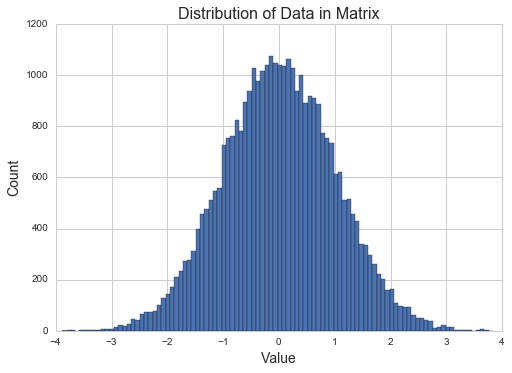

In [4]:
plt.title("Distribution of Data in Matrix", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Value", fontsize=14)
plt.hist(X_values, bins=100)
plt.show()

As expected, it appears to be a normal distribution that is centered around 0 with a variance of 1.

A core component of the matrix factorization model will be the embedding layer. This layer takes in an integer and outputs a dense array of learned features. This is widely used in natural language processing, where the input would be words, and the output might be the features related to that words' sentiment. The strength of this layer is the ability for the network to learn what useful features are instead of needing them to be predefined. Below is an illustrative example of the output of a two dimensional embedding layer. We can see that on the left words that mean similar things cluster together, such as languages towards the top and positive words near the bottom. One can do a similar thing for movies (on the right) and observe that comedies seem to cluster towards the center and sci-fi clusters closer to the bottom. This is useful for our model because if we learn that a user likes one comedy, we can infer that they will have a higher ranking for another comedy based on their co-localization in this embedding space.

<img src="embeddings.png" height="500" width="800">

In our implementation, the input dimension of the embedding layer is 250 because there are 250 rows and columns in the data we generated, and the output dimension is set to 25 in order to learn a lower dimensional representation of size 25. This can be set as high or low as desired, with a higher dimensional feature space potentially being more powerful but slower to learn, and potentially prone to overfitting as the model has more parameters.

In [5]:
user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=250, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=250, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")
y_pred = mx.symbol.sum_axis(data=(user * movie), axis=1)
y_pred = mx.symbol.flatten(y_pred)
y_pred = mx.symbol.LinearRegressionOutput(data=y_pred, label=y_true)

We just implemented vanilla matrix factorization! It is a fairly simple model when expressed this way. All we need to do is define an embedding layer for the users and one for the movies, then define the dot product between these two layers as the prediction. Keep in mind that while we've used MXNet to implement this model, it does not yet utilize a deep neural network.

We next need to convert our data from the form of three vectors (the row ids, column ids, and values) into an appropriate iterator that MXNet can use. Since we have multiple inputs (the movie and the user), the `NDArrayIter` object is the most convenient as it can handle arbitrary inputs and outputs through the use of dictionaries. By considering this problem on a single rating granularity instead of as the full matrix, we can transform the problem fairly simply into a supervised learning problem that plays well with the MXNet framework!

In [6]:
X_train = mx.io.NDArrayIter({'user': i[:25000], 'movie': j[:25000]}, label=X_values[:25000], batch_size=1000)
X_eval = mx.io.NDArrayIter({'user': i[25000:], 'movie': j[25000:]}, label=X_values[25000:], batch_size=1000)

We aren't quite done yet. We've only defined the symbolic architecture of the network. We now need to specify that the architecture is a model to be trained using the `Module` wrapper. We first define the context that the network will live on, either the CPU or GPU, the names of the inputs, and the final symbol in the network. In this tutorial we will use the CPU to train the network, but one could easily swap in a GPU using `mx.gpu(0)`, or many GPUs by passing in a list such as `[mx.gpu(0), mx.gpu(1)]`. Given that the examples that we are dealing with in this tutorial are fairly simple and don't involve convolutional layers, we won't need to harness to increased speed of a GPU.

In [7]:
model = mx.module.Module(context=mx.cpu(), data_names=('user', 'movie'), symbol=y_pred)

Next we need to fit the network using the `fit` function, similar to scikit-learn and other popular machine learning packages. We can specify the number of epochs that we would like to train for, the validation set data through `eval_data`, and the metric used to evaluate both the training and validation sets during training. In this case we choose root mean squared error (rmse), which is a common choice in regression problems such as this—it penalizes large errors more than small ones. This makes sense in a recommendation context, where offering a user something slightly unexpected may be a virtue, but getting a recommendation totally wrong will be off-putting to your user. 

In [8]:
model.fit(X_train, num_epoch=5, eval_metric='rmse', eval_data=X_eval)

INFO:root:Epoch[0] Train-rmse=1.009686
INFO:root:Epoch[0] Time cost=0.077
INFO:root:Epoch[0] Validation-rmse=1.014206
INFO:root:Epoch[1] Train-rmse=1.009686
INFO:root:Epoch[1] Time cost=0.085
INFO:root:Epoch[1] Validation-rmse=1.014206
INFO:root:Epoch[2] Train-rmse=1.009686
INFO:root:Epoch[2] Time cost=0.071
INFO:root:Epoch[2] Validation-rmse=1.014206
INFO:root:Epoch[3] Train-rmse=1.009686
INFO:root:Epoch[3] Time cost=0.046
INFO:root:Epoch[3] Validation-rmse=1.014206
INFO:root:Epoch[4] Train-rmse=1.009686
INFO:root:Epoch[4] Time cost=0.035
INFO:root:Epoch[4] Validation-rmse=1.014206


It doesn't really seem like it's training because the validation mean squared error is not changing epoch by epoch. This is because in the dataset we randomly generated there was no connection between the values in the matrix that could be exploited by a machine learning model—we just generated random values with no dependence on each other, and then blanked many of them out. The "movie watchers" don't have any preferences, they just randomly like or don't like movies! It would be impossible to predict what these values are using matrix factorization. This is a key concept to keep in mind-- if you don't believe there is any connection between the values that are observed and the values that are missing, it will be impossible to predict the missing values solely from the observed ones.

Let's now create some synthetic data that has structure that can be exploited instead of evenly distributed random values. We can do this by first randomly generated two lower rank matrices, one for the rows and one for the columns, and taking the dot product between them. This essentially mirrors the matrix factorization task by saying that there is a lower dimensional structure that our model can learn to be a good predictor of missing values.

In [9]:
a = numpy.random.normal(0, 1, size=(250, 25))
b = numpy.random.normal(0, 1, size=(25, 250))

X = a.dot(b)

n = 35000
i = numpy.random.randint(250, size=n)
j = numpy.random.randint(250, size=n)
X_values = X[i, j]

X_train = mx.io.NDArrayIter({'user': i[:25000], 'movie': j[:25000]}, label=X_values[:25000], batch_size=100)
X_eval = mx.io.NDArrayIter({'user': i[25000:], 'movie': j[25000:]}, label=X_values[25000:], batch_size=100)

Let's take a look at the distribution of data like before by plotting a histogram of the values in this matrix.

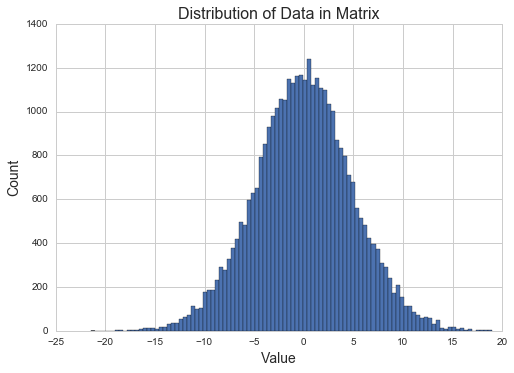

In [10]:
plt.title("Distribution of Data in Matrix", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Value", fontsize=14)
plt.hist(X_values, bins=100)
plt.show()

It looks like another normal distribution, except with a larger variance. This makes sense theoretically, because the dot product of two matrices of normally distributed values is also normally distributed. 

Now that we've created this new dataset and the appropriate iterators, we can create the model again and try to learn something.

In [11]:
model = mx.module.Module(context=mx.cpu(), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, eval_metric='mse', eval_data=X_eval)

INFO:root:Epoch[0] Train-mse=24.250952
INFO:root:Epoch[0] Time cost=0.206
INFO:root:Epoch[0] Validation-mse=24.078770
INFO:root:Epoch[1] Train-mse=24.250941
INFO:root:Epoch[1] Time cost=0.238
INFO:root:Epoch[1] Validation-mse=24.078767
INFO:root:Epoch[2] Train-mse=24.250929
INFO:root:Epoch[2] Time cost=0.149
INFO:root:Epoch[2] Validation-mse=24.078764
INFO:root:Epoch[3] Train-mse=24.250918
INFO:root:Epoch[3] Time cost=0.188
INFO:root:Epoch[3] Validation-mse=24.078761
INFO:root:Epoch[4] Train-mse=24.250907
INFO:root:Epoch[4] Time cost=0.199
INFO:root:Epoch[4] Validation-mse=24.078758


It doesn't seem like we're learning anything again because neither the training nor the validation mse goes down epoch by epoch! The problem this time is that, like many matrix factorization algorithms, we are using stochastic gradient descent (SGD) which is tricky to set an appropriate learning rate for. However, since we've implemented matrix factorization using Apache MXNet we can easily use a different optimizer. [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) is a popular optimizer that can automatically tune the learning rate to get better results, and we can specify that we want to use it by adding in `optimizer='adam'` to the `fit` function.

In [12]:
model = mx.module.Module(context=mx.cpu(), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', eval_metric='mse', eval_data=X_eval)

INFO:root:Epoch[0] Train-mse=23.469048
INFO:root:Epoch[0] Time cost=0.273
INFO:root:Epoch[0] Validation-mse=21.070660
INFO:root:Epoch[1] Train-mse=15.098957
INFO:root:Epoch[1] Time cost=0.229
INFO:root:Epoch[1] Validation-mse=14.016162
INFO:root:Epoch[2] Train-mse=8.175886
INFO:root:Epoch[2] Time cost=0.226
INFO:root:Epoch[2] Validation-mse=10.487469
INFO:root:Epoch[3] Train-mse=5.157359
INFO:root:Epoch[3] Time cost=0.218
INFO:root:Epoch[3] Validation-mse=8.288769
INFO:root:Epoch[4] Train-mse=3.552385
INFO:root:Epoch[4] Time cost=0.232
INFO:root:Epoch[4] Validation-mse=6.721521


That is much better! It looks like we are able to get significantly improved results using the Adam optimizer rather than SGD. It also appears that the model is able to perform extremely well on a validation set. This is likely because the task is fairly easy: we synthetically created our dataset without noise from a low dimensional representation, and then learned that representation using matrix factorization.

Let's now take a look at what deep matrix factorization would look like. Essentially, we want to replace the dot product that turns the factors into a prediction with a neural network that takes in the factors as input and predicts the output. We can modify the model code fairly simply to achieve this.

In [13]:
user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=250, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=250, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")

# No longer using a dot product
#y_pred = mx.symbol.sum_axis(data=(user * movie), axis=1)
#y_pred = mx.symbol.flatten(y_pred)
#y_pred = mx.symbol.LinearRegressionOutput(data=y_pred, label=y_true)

# Now using a neural network
nn = mx.symbol.concat(user, movie)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.cpu(), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),), 
          eval_metric='mse', eval_data=X_eval)

INFO:root:Epoch[0] Train-mse=24.251155
INFO:root:Epoch[0] Time cost=0.386
INFO:root:Epoch[0] Validation-mse=24.073365
INFO:root:Epoch[1] Train-mse=24.069941
INFO:root:Epoch[1] Time cost=0.346
INFO:root:Epoch[1] Validation-mse=23.996876
INFO:root:Epoch[2] Train-mse=23.561898
INFO:root:Epoch[2] Time cost=0.367
INFO:root:Epoch[2] Validation-mse=23.830399
INFO:root:Epoch[3] Train-mse=23.010173
INFO:root:Epoch[3] Time cost=0.335
INFO:root:Epoch[3] Validation-mse=23.646338
INFO:root:Epoch[4] Train-mse=22.609636
INFO:root:Epoch[4] Time cost=0.321
INFO:root:Epoch[4] Validation-mse=23.523100


The only difference to our code is that we have to define a neural network. The inputs to this network are the concatenated factors from the embedding layer, created using `mx.symbol.concat`. Next, we flatten the result just to ensure the right shape using `mx.symbol.flatten`. and then use `mx.symbol.FullyConnected` and `mx.symbol.Activation` layers as necessary to define the network. The final fully connected layer must have a single node, as this is the final prediction that the network is making.

We can see that while the neural network is clearly training due to the validation mse decreasing after each epoch, it is not decreasing as quickly as normal matrix factorization. The optimal learning parameters are almost always different between the two due to the neural network's added complexity. In this tutorial we won't pursue the optimal values for hyperparameters like learning rate or weight decay, but instead focus structurally on the things you can do with deep matrix factorization.

## MovieLens 20M

Now let's move on to a real example using the MovieLens 20M dataset. This data is comprised of movie ratings from the MovieLens site (<a href="https://movielens.org/">https://movielens.org/</a>), a site that will predict what other movies you will like after seeing you rate movies. The MovieLens 20M dataset is a sampling of ~20 million ratings from ~138 thousand users on ~27 thousand movies. The ratings range from 0.5 to 5 stars in 0.5 star increments.

<b>NOTE</b>: Given that we are about to train neural networks on millions of samples, the following cells may take some time to execute on a CPU and may produce a lot of output. At least 6GB of RAM is suggested for running the cells. If you have a GPU or a cloud environment, now would be the time to use it (you can stand up an [AWS Machine Image](https://aws.amazon.com/amazon-ai/amis/) for deep learning fairly straightforwardly, for example). 

Let's first load up the data and inspect it manually.

In [14]:
import os
import urllib.request
import zipfile

if not os.path.exists('ml-20m.zip'):
    urllib.request.urlretrieve('http://files.grouplens.org/datasets/movielens/ml-20m.zip', 'ml-20m.zip')
with zipfile.ZipFile("ml-20m.zip", "r") as f:
    f.extractall("./")

data = pandas.read_csv('./ml-20m/ratings.csv', sep=',', usecols=(0, 1, 2))
data.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


It looks like there are slightly over 20M ratings that comprise a user ID, a movie ID, and a rating in 0.5 star increments. Each one of these rows will be a sample to train on, as we want our model to take in a user and a movie and predict the rating that user would give to that movie. Let's take a look at the distribution of ratings before moving on.

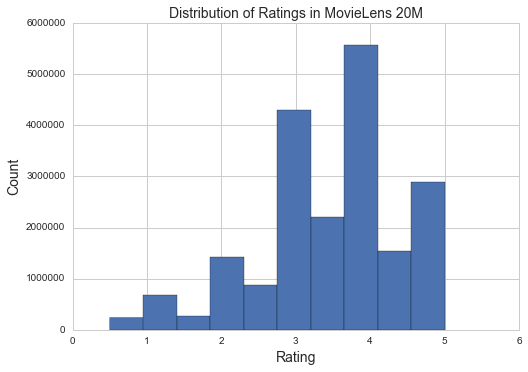

In [15]:
plt.hist(data['rating'])
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Ratings in MovieLens 20M", fontsize=14)
plt.show()

It looks like this is fairly normal distribution, with the most ratings being that a movie was good but not amazing, and the fewest ratings that movies were very poor. It also seems like people were more reluctant to rate a movie using one of the half star increments than with the full star increments. 

Let's next quickly look at the users and movies. Specifically, let's look at the maximum and minimum id values, and the number of unique users and movies.

In [16]:
print("user id min/max: ", data['userId'].min(), data['userId'].max())
print("# unique users: ", numpy.unique(data['userId']).shape[0])
print("")
print("movie id min/max: ", data['movieId'].min(), data['movieId'].max())
print("# unique movies: ", numpy.unique(data['movieId']).shape[0])

user id min/max:  1 138493
# unique users:  138493

movie id min/max:  1 131262
# unique movies:  26744


It looks like the max user ID is equal to the number of unique users, but this is not the case for the number of movies. Good thing that we caught this now, otherwise we may have encountered errors if we assumed that because there are only 26744 unique movies that the maximum movie ID was 26744 as well. Let's quickly set these sizes so that later on we can set the embedding layer size appropriately.

In [17]:
n_users, n_movies = 138493, 131262
batch_size = 25000

We can quickly estimate the sparsity of the MovieLens 20M dataset using these numbers. If there are ~138k unique users and ~27k unique movies, then there are ~3.7 billion entries in the matrix. Since only ~20M of these are present, ~99.5% of the matrix is missing. This type of massive sparsity is common in recommender systems and underlies the necessity of building models that can leverage the existing data to learn complex relationships.

Next, we need to split the data into a training set and a test set. Let's first shuffle the data to ensure that the data is randomly selected, then we can use the first 19 million samples for training and the remaining for the test set.

In [18]:
n = 19000000

data = data.sample(frac=1).reset_index(drop=True) # Shuffle the data in place row-wise

train_users = data['userId'].values[:n] - 1 # Offset by 1
train_movies = data['movieId'].values[:n] - 1 # Offset by 1 
train_ratings = data['rating'].values[:n]

valid_users = data['userId'].values[n:] - 1
valid_movies = data['movieId'].values[n:] - 1
valid_ratings = data['rating'].values[n:]

Let's first see how well vanilla matrix factorization works on this example. We use roughly the same code from before, creating a `NDArrayIter` from the actual MovieLens dataset rather than from synthetically generated data. We'll keep all optimization parameters the same for this example.

In [19]:
X_train = mx.io.NDArrayIter({'user': train_users, 'movie': train_movies}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'movie': valid_movies}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")
y_pred = mx.symbol.sum_axis(data=(user * movie), axis=1)
y_pred = mx.symbol.flatten(y_pred)
y_pred = mx.symbol.LinearRegressionOutput(data=y_pred, label=y_true)

model = mx.module.Module(context=mx.cpu(), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [250]	Speed: 200059.34 samples/sec	rmse=3.358977
INFO:root:Epoch[0] Batch [500]	Speed: 192168.53 samples/sec	rmse=1.812172
INFO:root:Epoch[0] Batch [750]	Speed: 164999.06 samples/sec	rmse=1.181464
INFO:root:Epoch[0] Train-rmse=1.059567
INFO:root:Epoch[0] Time cost=103.198
INFO:root:Epoch[0] Validation-rmse=1.060748
INFO:root:Epoch[1] Batch [250]	Speed: 177878.44 samples/sec	rmse=1.002401
INFO:root:Epoch[1] Batch [500]	Speed: 191904.70 samples/sec	rmse=0.936251
INFO:root:Epoch[1] Batch [750]	Speed: 186608.02 samples/sec	rmse=0.904792
INFO:root:Epoch[1] Train-rmse=0.889933
INFO:root:Epoch[1] Time cost=102.346
INFO:root:Epoch[1] Validation-rmse=0.895546
INFO:root:Epoch[2] Batch [250]	Speed: 144105.82 samples/sec	rmse=0.887525
INFO:root:Epoch[2] Batch [500]	Speed: 169424.02 samples/sec	rmse=0.878834
INFO:root:Epoch[2] Batch [750]	Speed: 184188.96 samples/sec	rmse=0.873441
INFO:root:Epoch[2] Train-rmse=0.866750
INFO:root:Epoch[2] Time cost=115.381
INFO:root:Epoch[2]

It looks like we're learning something on this dataset! We can see that both the training and the validation RMSE decrease epoch by epoch. Each epoch takes significantly longer than with the synthetic data because we're training on nineteen million examples instead of twenty-five thousand. 

Let's now turn to deep matrix factorization. We'll use similar code as before, where we concatenate together the two embedding layers and use that as input to two fully connected layers. This network will have the same sized embedding layers as the normal matrix factorization and optimization parameters, meaning that the only change is that a neural network is doing the prediction instead of a dot product.

In [20]:
X_train = mx.io.NDArrayIter({'user': train_users, 'movie': train_movies}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'movie': valid_movies}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.cpu(), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [250]	Speed: 118637.11 samples/sec	rmse=1.534038
INFO:root:Epoch[0] Batch [500]	Speed: 113050.06 samples/sec	rmse=0.870649
INFO:root:Epoch[0] Batch [750]	Speed: 103719.93 samples/sec	rmse=0.864005
INFO:root:Epoch[0] Train-rmse=0.857448
INFO:root:Epoch[0] Time cost=171.698
INFO:root:Epoch[0] Validation-rmse=0.860733
INFO:root:Epoch[1] Batch [250]	Speed: 78250.38 samples/sec	rmse=0.859745
INFO:root:Epoch[1] Batch [500]	Speed: 101016.08 samples/sec	rmse=0.855493
INFO:root:Epoch[1] Batch [750]	Speed: 119003.66 samples/sec	rmse=0.845985
INFO:root:Epoch[1] Train-rmse=0.836734
INFO:root:Epoch[1] Time cost=196.198
INFO:root:Epoch[1] Validation-rmse=0.841941
INFO:root:Epoch[2] Batch [250]	Speed: 122335.95 samples/sec	rmse=0.837715
INFO:root:Epoch[2] Batch [500]	Speed: 115161.64 samples/sec	rmse=0.832515
INFO:root:Epoch[2] Batch [750]	Speed: 125680.21 samples/sec	rmse=0.829576
INFO:root:Epoch[2] Train-rmse=0.824149
INFO:root:Epoch[2] Time cost=156.961
INFO:root:Epoch[2] 

Looks like we're getting a lower validation rmse after 5 epochs using deep matrix factorization than with normal matrix factorization! That is a promising start that one could likely build on by toying with the hyperparameters, activation functions, or structure of the network.

It is important to keep in mind that we are training a neural network, and so all of the advances in deep learning can be immediately applied to deep matrix factorization. A widely used advance was that of batch normalization, which essentially tried to shrink the range of values that the internal nodes in a network, ultimately speeding up training. We can use batch normalization layers in our network here as well simply by modifying the network to add these layers in between the fully connected layers and the activation layers.

In [21]:
X_train = mx.io.NDArrayIter({'user': train_users, 'movie': train_movies}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'movie': valid_movies}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.BatchNorm(data=nn) # First batch norm layer here!
nn = mx.symbol.Activation(data=nn, act_type='relu') 
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.BatchNorm(data=nn) # Second batch norm layer here!
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.cpu(), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [250]	Speed: 39208.91 samples/sec	rmse=1.396967
INFO:root:Epoch[0] Batch [500]	Speed: 37904.94 samples/sec	rmse=0.861666
INFO:root:Epoch[0] Batch [750]	Speed: 38629.65 samples/sec	rmse=0.846601
INFO:root:Epoch[0] Train-rmse=0.837209
INFO:root:Epoch[0] Time cost=492.430
INFO:root:Epoch[0] Validation-rmse=0.840387
INFO:root:Epoch[1] Batch [250]	Speed: 38216.81 samples/sec	rmse=0.833456
INFO:root:Epoch[1] Batch [500]	Speed: 36666.01 samples/sec	rmse=0.824795
INFO:root:Epoch[1] Batch [750]	Speed: 39337.02 samples/sec	rmse=0.820960
INFO:root:Epoch[1] Train-rmse=0.812641
INFO:root:Epoch[1] Time cost=498.679
INFO:root:Epoch[1] Validation-rmse=0.833002
INFO:root:Epoch[2] Batch [250]	Speed: 40163.91 samples/sec	rmse=0.807429
INFO:root:Epoch[2] Batch [500]	Speed: 40749.31 samples/sec	rmse=0.810349
INFO:root:Epoch[2] Batch [750]	Speed: 41163.72 samples/sec	rmse=0.811134
INFO:root:Epoch[2] Train-rmse=0.808280
INFO:root:Epoch[2] Time cost=466.423
INFO:root:Epoch[2] Validati

It seems like for this specific dataset, batch normalization does cause the network to converge faster, but does not produce a significantly better model. Despite this, one may find that it does help with their dataset, particularly if that dataset requires a deeper network than the two layered one used here.

An alternate approach to this model is to consider the problem a classification problem instead of a regression problem. In the classification approach, the classes are the various ratings, and one attempts a 10 class problem, since there are 10 possible ratings that a film can get. The only modification to the data needed is to modify the ratings to be integers between 0 and 9 instead of 0 to 5 with 0.5 star spacing. The network needs only be modified to have 10 hidden units in the final layer, since it is now a 10 class problem, and to use the softmax output designed for classification problems instead of the linear regression output designed for regression problems. Lastly, since this is a classification problem, we want to use accuracy as the evaluation metric instead of RMSE.

In [22]:
X_train = mx.io.NDArrayIter({'user': train_users, 'movie': train_movies}, 
                            label=train_ratings*2-1, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'movie': valid_movies}, 
                           label=valid_ratings*2-1, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=10) # 10 hidden units because 10 classes

y_pred = mx.symbol.SoftmaxOutput(data=nn, label=y_true) # SoftmaxOutput instead of LinearRegressionOutput
#y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.cpu(), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='acc', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [250]	Speed: 122794.92 samples/sec	accuracy=0.277911
INFO:root:Epoch[0] Batch [500]	Speed: 114745.76 samples/sec	accuracy=0.308079
INFO:root:Epoch[0] Batch [750]	Speed: 120039.00 samples/sec	accuracy=0.352916
INFO:root:Epoch[0] Train-accuracy=0.369453
INFO:root:Epoch[0] Time cost=159.667
INFO:root:Epoch[0] Validation-accuracy=0.369045
INFO:root:Epoch[1] Batch [250]	Speed: 119471.48 samples/sec	accuracy=0.374056
INFO:root:Epoch[1] Batch [500]	Speed: 121729.90 samples/sec	accuracy=0.381145
INFO:root:Epoch[1] Batch [750]	Speed: 122073.81 samples/sec	accuracy=0.386917
INFO:root:Epoch[1] Train-accuracy=0.391404
INFO:root:Epoch[1] Time cost=156.781
INFO:root:Epoch[1] Validation-accuracy=0.386814
INFO:root:Epoch[2] Batch [250]	Speed: 122468.00 samples/sec	accuracy=0.390450
INFO:root:Epoch[2] Batch [500]	Speed: 122347.94 samples/sec	accuracy=0.394187
INFO:root:Epoch[2] Batch [750]	Speed: 119624.61 samples/sec	accuracy=0.397321
INFO:root:Epoch[2] Train-accuracy=0.400560

It does appear that the network is getting more accurate over time, but accuracy results aren't directly comparable to the RMSE results. We can convert the results that we got to RMSE by taking the most likely rating as the predicted value (using the argmax function on the vector of probabilities predicted for each rating) and calculating RMSE ourselves.

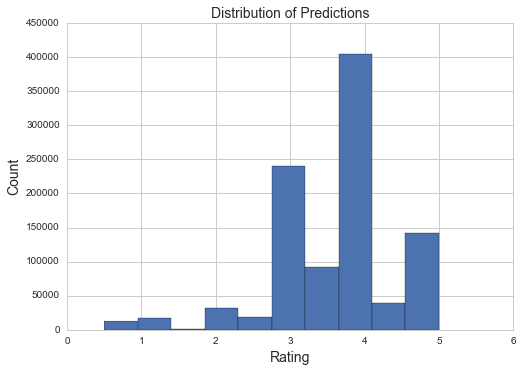

In [23]:
y_pred = model.predict(X_eval).asnumpy().argmax(axis=1)
y_pred = (y_pred + 1.) / 2

plt.title("Distribution of Predictions", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Rating", fontsize=14)
plt.hist(y_pred)
plt.show()

RMSE is simple to implement ourselves and calculate.

In [24]:
numpy.sqrt(((y_pred - valid_ratings) ** 2).mean())

0.94985115511429619

It appears that this methid does not work that well compared to optimizing the RMSE directly for this specific dataset. However, this opens the door to using MXNet to solve all types of matrix completion problems that have categories that need to be predicted instead of real values. It is very easy to transfer from a regression approach to a classification approach when using a neural network, and that simplicity transfers over to deep matrix factorization as well.

## Structural Regularization in Deep Matrix Factorization

Another aspect of deep matrix factorization's flexibility over that of vanilla matrix factorization is the `output_dim` size of the embedding layers. For vanilla matrix factorization these values must be the same for both inputs because the prediction is the dot product between the two. However, if these serve as the input for a neural network, this restriction goes away. This is useful in the case where one dimension may be significantly larger than the other and thus requires training a massive number of factors. In the MovieLens case there are significantly more users (~138k) than there are movies (~27k). By changing the number of user factors from 25 to 15 we can reduce the number of parameters by 1.38 million while not losing any expressivity on the movie side. The only change is changing the value of `output_dim` in the user embedding layer.

In [25]:
X_train = mx.io.NDArrayIter({'user': train_users, 'movie': train_movies}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'movie': valid_movies}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=15) # Using 15 instead of 25 here

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu') 
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.cpu(), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [250]	Speed: 145962.10 samples/sec	rmse=1.514931
INFO:root:Epoch[0] Batch [500]	Speed: 148807.95 samples/sec	rmse=0.870363
INFO:root:Epoch[0] Batch [750]	Speed: 145735.88 samples/sec	rmse=0.863618
INFO:root:Epoch[0] Train-rmse=0.857462
INFO:root:Epoch[0] Time cost=129.353
INFO:root:Epoch[0] Validation-rmse=0.860865
INFO:root:Epoch[1] Batch [250]	Speed: 133382.85 samples/sec	rmse=0.859818
INFO:root:Epoch[1] Batch [500]	Speed: 141339.16 samples/sec	rmse=0.854639
INFO:root:Epoch[1] Batch [750]	Speed: 143850.40 samples/sec	rmse=0.843351
INFO:root:Epoch[1] Train-rmse=0.834700
INFO:root:Epoch[1] Time cost=136.112
INFO:root:Epoch[1] Validation-rmse=0.839810
INFO:root:Epoch[2] Batch [250]	Speed: 147025.64 samples/sec	rmse=0.835836
INFO:root:Epoch[2] Batch [500]	Speed: 146040.68 samples/sec	rmse=0.831258
INFO:root:Epoch[2] Batch [750]	Speed: 145320.30 samples/sec	rmse=0.828088
INFO:root:Epoch[2] Train-rmse=0.822267
INFO:root:Epoch[2] Time cost=129.913
INFO:root:Epoch[2]

It seems like we are getting similar accuracy with drastically fewer parameters. This is useful in a setting where you may run out of memory due to the size of the matrix being completed, or as a way to reduce overfitting by using a simpler model. One can imagine that perhaps movies might be difficult to appropriately represent and have many aspects that should be modeled, whereas users are simpler and only have a few features that are relevant. Being able to tune the size of these embedding layers is a very useful tool.

Next, we can extend matrix factorization past using only two embedding layers. The MovieLens dataset comes with genres for each of the films. Presumably genre is one of the major aspects that would be learned by the movie embedding layer already, so explicitly including that information can be beneficial. More broadly, perhaps there are some features that are common to a ~genre~ of films instead of an individual film. By modeling the genre of film as its own embedding layer, we can train these factors using all films of a given genre instead of trying to learn the value of the respective factor for each movie individually. Since we've already seen that the number of factors in each layer can be variable, we don't need to be concerned with the size of any of these layers. We can see that visually below. Assuming that movies have been sorted by genre, we can see that half of the movie factors now correspond more broadly to the genre that they are in and are shared across movies, while the other half are still movie specific factors. The change to the network is conceptually very simple, now concatenating three embedding layers to be the input to the network instead of only two.

<img src="embedding-layers.png">

Let's first load up the genre data.

In [26]:
genres = pandas.read_csv('./ml-20m/movies.csv')
genres.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


It looks like this dataset is simple, it just has all of the genres and the corresponding title and movieId. For simplicity, let's only use the first genre of the many that are specified, and determine a unique ID for each of the genres. Modeling all the genres applied to a movie is left as an exercise for the reader (hint: instead of label, use a one- or multiple-hot vector!).

In [27]:
labels_str = [label.split("|")[0] for label in genres['genres']]
label_set = numpy.unique(labels_str)
label_idxs = {l: i for i, l in enumerate(label_set)}
label_idxs

{'(no genres listed)': 0,
 'Action': 1,
 'Adventure': 2,
 'Animation': 3,
 'Children': 4,
 'Comedy': 5,
 'Crime': 6,
 'Documentary': 7,
 'Drama': 8,
 'Fantasy': 9,
 'Film-Noir': 10,
 'Horror': 11,
 'IMAX': 12,
 'Musical': 13,
 'Mystery': 14,
 'Romance': 15,
 'Sci-Fi': 16,
 'Thriller': 17,
 'War': 18,
 'Western': 19}

It looks like there are 20 genres, with one being that no genres are listed. This seems appropriate. We want our network to now take in three numbers, the user ID, the movie ID, and the movie genre ID. This will allow us to train factors specific to all romance movies, for example, or all fantasy movies.

In [28]:
labels = numpy.empty(n_movies)
for movieId, label in zip(genres['movieId'], labels_str):
    labels[movieId-1] = label_idxs[label]

train_genres = numpy.array([labels[int(j)] for j in train_movies])
valid_genres = numpy.array([labels[int(j)] for j in valid_movies])
train_genres[:10]

array([  5.,   5.,   1.,   5.,  11.,   8.,   5.,   2.,   5.,   2.])

Now we have our three labels. We need to move our data iterator to take in movie type as a third input, and our network to have a third embedding layer. Let's move five factors over from the movie factors to this new movie genre embedded layer. This is another way one can attempt to structurally regularize their model, as roughly 135,000 parameters are removed from the movie embedding layer, and only 100 are added in the genre layer. The input to the network remains the same size, 40, but the values are now comprised of three layers instead of just two.

In [29]:
X_train = mx.io.NDArrayIter({'user': train_users, 'movie': train_movies, 'movie_genre': train_genres}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'movie': valid_movies, 'movie_genre': valid_genres}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=15)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=20) # Reduce by 5

# We need to add in a third embedding layer for genre
movie_genre = mx.symbol.Variable("movie_genre")
movie_genre = mx.symbol.Embedding(data=movie_genre, input_dim=20, output_dim=5) # Set to 5

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie, movie_genre)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.cpu(), data_names=('user', 'movie', 'movie_genre'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [250]	Speed: 152348.60 samples/sec	rmse=1.543478
INFO:root:Epoch[0] Batch [500]	Speed: 156112.50 samples/sec	rmse=0.869655
INFO:root:Epoch[0] Batch [750]	Speed: 158070.14 samples/sec	rmse=0.863854
INFO:root:Epoch[0] Train-rmse=0.857693
INFO:root:Epoch[0] Time cost=122.266
INFO:root:Epoch[0] Validation-rmse=0.861068
INFO:root:Epoch[1] Batch [250]	Speed: 157670.08 samples/sec	rmse=0.860133
INFO:root:Epoch[1] Batch [500]	Speed: 150558.44 samples/sec	rmse=0.858514
INFO:root:Epoch[1] Batch [750]	Speed: 156919.67 samples/sec	rmse=0.857988
INFO:root:Epoch[1] Train-rmse=0.852612
INFO:root:Epoch[1] Time cost=122.420
INFO:root:Epoch[1] Validation-rmse=0.857694
INFO:root:Epoch[2] Batch [250]	Speed: 155068.93 samples/sec	rmse=0.854496
INFO:root:Epoch[2] Batch [500]	Speed: 154660.07 samples/sec	rmse=0.846820
INFO:root:Epoch[2] Batch [750]	Speed: 151527.08 samples/sec	rmse=0.840205
INFO:root:Epoch[2] Train-rmse=0.832399
INFO:root:Epoch[2] Time cost=123.495
INFO:root:Epoch[2]

While it doesn't appear that using only the first genre has led to much improvement on this dataset, it demonstrates the types of things that one could do with the flexibility afforded by deep matrix factorization. In order to model all possible genres, perhaps one would create one embedding layer per genre that can either be 0 meaning the movie is not a part of that genre or a 1 meaning that it is. Alternatively, one could create a dense input vector that is encoded in the same way to replace the many embedding layers with a single input layer. Depending on the amount of information that is present for each user one may choose to add this type of structural regularization on the user axis as well.

## Conclusion

In this tutorial we investigated both traditional and deep matrix factorization and showed how one would use Apache MXNet to implement these models. Since these types of matrix factorization models are commonly used to build recommender systems, we showed how to build models to predict user ratings of movies using the MovieLens 20M dataset. We saw that deep matrix factorization can natively take advantage of the recent advances in deep learning to learn more sophisticated models. In addition, deep matrix factorization can take advantage of the flexibility afforded by neural networks to allow more complicated inputs than traditional matrix factorization can handle that could yield additional insight into the task. Apache MXNet makes doing all of this simple, as with only about two dozen lines of code one can define both the model and how to train it. Since MXNet is built with distributed computing in mind it is easy to take advantage of those built-in features to scale this type of model up to massive datasets that can't fit in memory.

For further reading, the <a href="https://github.com/apache/incubator-mxnet/tree/master/example/recommenders">MXNet GitHub page</a> offers several tutorials on how to use MXNet to implement many types of recommender systems. Leo Dirac also has an <a href="https://www.youtube.com/watch?v=cftJAuwKWkA">excellent tutorial</a> on using MXNet for recommender systems that is worth watching.